In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = ALL, 1 = WARNING, 2 = ERROR, 3 = FATAL

In [3]:
import pandas as pd
label2id = None
id2label = None

label2id = {'long sleeve outwear': 0,
 'trousers': 1,
 'short sleeve top': 2,
 'skirt': 3,
 'short sleeve dress': 4,
 'shorts': 5,
 'vest': 6,
 'vest dress': 7,
 'long sleeve top': 8,
 'long sleeve dress': 9,
 'sling dress': 10,
 'sling': 11,
 'short sleeve outwear': 12}
id2label = {0: 'long sleeve outwear',
 1: 'trousers',
 2: 'short sleeve top',
 3: 'skirt',
 4: 'short sleeve dress',
 5: 'shorts',
 6: 'vest',
 7: 'vest dress',
 8: 'long sleeve top',
 9: 'long sleeve dress',
 10: 'sling dress',
 11: 'sling',
 12: 'short sleeve outwear'}

def get_dataframe(name="train"):
    global label2id, id2label
    df = pd.read_csv(f"../archive/DeepFashion2/img_info_dataframes/{name}.csv")
    df["label"] = df["category_name"]
    #if name == "train":
    #    label2id = {label: idx for idx, label in enumerate(df["label"].unique())}
    #    id2label = {idx: label for label, idx in label2id.items()}
        
    df["label_id"] = df["label"].map(label2id)
    df["path"] = df["path"].apply(lambda item: item.replace("/kaggle/input/deepfashion2-original-with-dataframes", "../archive/"))
    return df

In [4]:
df = get_dataframe("train")
df_val = get_dataframe("validation")

In [5]:
import numpy as np
duplicates_clothes = df.groupby("path").size().reset_index()
duplicates_clothes.columns = ["path", "count"]
no_multiple_cases = duplicates_clothes[duplicates_clothes["count"] == 1]["path"].to_list()

duplicates_clothes = df_val.groupby("path").size().reset_index()
duplicates_clothes.columns = ["path", "count"]
no_multiple_cases_val = duplicates_clothes[duplicates_clothes["count"] == 1]["path"].to_list()

df_val = df_val[df_val["path"].isin(no_multiple_cases_val)]

In [15]:
from sklearn.utils import resample

# Filtrar el dataset
filtered_df = df[df["path"].isin(no_multiple_cases) | df["category_name"].isin(["skirt", "short sleeve outwear", "sling"])]

# Calcular cuántas clases hay
n_classes = filtered_df["label_id"].nunique()

# Calcular máximo número que podemos tomar por clase sin duplicar
samples_per_class = min(
    filtered_df["label_id"].value_counts().min(),
    10_016 // n_classes
)

# Tomar muestras sin reemplazo
balanced_samples = (
    filtered_df.groupby("label_id", group_keys=False)
    .apply(lambda x: x.sample(n=samples_per_class, random_state=12345))
)

# Ajustar el tamaño final si sobra o falta alguna
balanced_samples = balanced_samples.sample(n=min(len(balanced_samples), 10_016), random_state=12345)

short_df = balanced_samples.reset_index(drop=True)


/tmp/ipykernel_9804/896389903.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=samples_per_class, random_state=12345))


In [16]:
df.groupby("category_name").size()

category_name
long sleeve dress        7907
long sleeve outwear     13457
long sleeve top         36064
short sleeve dress      17211
short sleeve outwear      543
short sleeve top        71645
shorts                  36616
skirt                   30835
sling                    1985
sling dress              6492
trousers                55387
vest                    16095
vest dress              17949
dtype: int64

In [19]:
short_df.groupby("category_name").size()

category_name
long sleeve dress       543
long sleeve outwear     543
long sleeve top         543
short sleeve dress      543
short sleeve outwear    543
short sleeve top        543
shorts                  543
skirt                   543
sling                   543
sling dress             543
trousers                543
vest                    543
vest dress              543
dtype: int64

In [20]:
df_val.groupby("path").size().unique()
df_val.shape

(12684, 14)

In [21]:
import tensorflow as tf

IMG_SIZE = 248
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def decode_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0  # Normalizar
    return image, label

def prepare_dataset(df, shuffle=True):
    paths = df["path"].values
    labels = df["label_id"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=20_000)  # optimize memory
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    #ds = ds.repeat()
    ds = ds.apply(tf.data.experimental.ignore_errors())
    return ds

train_ds = prepare_dataset(short_df)
val_ds = prepare_dataset(df_val, shuffle=False)

2025-05-13 18:17:21.258522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747153041.347018    9804 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747153041.372374    9804 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747153041.552755    9804 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747153041.552794    9804 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747153041.552814    9804 computation_placer.cc:177] computation placer alr

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [38]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers, models

def sparse_top_k_categorical_accuracy(y_true, y_pred, k=4):
    # Convierte etiquetas de enteros a one-hot para que funcione con top_k
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    return top_k_categorical_accuracy(y_true, y_pred, k=k)
    
base_model = EfficientNetV2B0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")

In [39]:
#base_model.summary()

In [44]:
base_model.layers[-8:]

[<Multiply name=block6h_se_excite, built=True>,
 <Conv2D name=block6h_project_conv, built=True>,
 <BatchNormalization name=block6h_project_bn, built=True>,
 <Dropout name=block6h_drop, built=True>,
 <Add name=block6h_add, built=True>,
 <Conv2D name=top_conv, built=True>,
 <BatchNormalization name=top_bn, built=True>,
 <Activation name=top_activation, built=True>]

In [41]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import top_k_categorical_accuracy

def sparse_top_k_categorical_accuracy(y_true, y_pred, k=4):
    # Convierte etiquetas de enteros a one-hot para que funcione con top_k
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    return top_k_categorical_accuracy(y_true, y_pred, k=k)
    
base_model = EfficientNetV2B0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")

# Primero descongela el modelo base
base_model.trainable = True

# Congela todo por defecto
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers:
    if any(name in layer.name for name in ["block6h_se_excite", "block6h_project_bn", "block6h_drop", "block6h_add", "top_conv", "top_bn", "top_activation"]):
        layer.trainable = True
        
model_efficient = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(len(label2id), activation="softmax")
])

top_4_accuracy = lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=4)
top_2_accuracy = lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=2)

model_efficient.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy",top_4_accuracy,top_2_accuracy]
)

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.callbacks import TensorBoard
import datetime


checkpoint_cb = ModelCheckpoint(
    filepath='models/efficient_ft/best_model.h5',             # O .keras para el nuevo formato
    monitor='val_accuracy',               # Métrica que decides monitorear
    save_best_only=True,                  # Guarda solo el mejor modelo
    mode='max',                           # Porque estás maximizando
    verbose=1
)

log_dir = "logs/fit/effnet/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_cb = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,            # Si quieres histogramas de activaciones
    write_graph=True,            # Guarda el grafo del modelo
    write_images=True            # Guarda imágenes de pesos y outputs (opcional)
)



In [43]:
from tensorflow.keras.callbacks import EarlyStopping

#early_stop_cb = EarlyStopping(
#    monitor='val_lambda',
#    patience=10,
#    restore_best_weights=True,
#    mode='max',
#    verbose=1
#)

history = model_efficient.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[ checkpoint_cb, tensorboard_cb]
)

Epoch 1/100
    221/Unknown 29s 57ms/step - accuracy: 0.0762 - lambda: 0.3017 - lambda_1: 0.1487 - loss: 2.5896 
Epoch 1: val_accuracy improved from -inf to 0.08333, saving model to models/efficient_ft/best_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 45s 128ms/step - accuracy: 0.0761 - lambda: 0.3017 - lambda_1: 0.1487 - loss: 2.5896 - val_accuracy: 0.0833 - val_lambda: 0.2539 - val_lambda_1: 0.1209 - val_loss: 2.5682
Epoch 2/100
218/221 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0888 - lambda: 0.3117 - lambda_1: 0.1578 - loss: 2.5799
Epoch 2: val_accuracy did not improve from 0.08333
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.0887 - lambda: 0.3116 - lambda_1: 0.1578 - loss: 2.5799 - val_accuracy: 0.0089 - val_lambda: 0.0921 - val_lambda_1: 0.0314 - val_loss: 2.5787
Epoch 3/100
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0763 - lambda: 0.3231 - lambda_1: 0.1614 - loss: 2.5737
Epoch 3: val_accuracy did not improve from 0.08333
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.0763 - lambda: 0.3231 - lambda_1: 0.1614 - loss: 2.5737 - val_accuracy: 0.0382 - val_lambda: 0.1665 - val_lambda_1: 0.1049 - val_loss: 2.5855
Epoch 4/100
218/221 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/ste

221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - accuracy: 0.0832 - lambda: 0.3084 - lambda_1: 0.1596 - loss: 2.5809 - val_accuracy: 0.1187 - val_lambda: 0.3574 - val_lambda_1: 0.2126 - val_loss: 2.5670
Epoch 5/100
218/221 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0726 - lambda: 0.3219 - lambda_1: 0.1586 - loss: 2.5765
Epoch 5: val_accuracy did not improve from 0.11873
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.0726 - lambda: 0.3218 - lambda_1: 0.1586 - loss: 2.5765 - val_accuracy: 0.0451 - val_lambda: 0.2342 - val_lambda_1: 0.1030 - val_loss: 2.5726
Epoch 6/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0760 - lambda: 0.3188 - lambda_1: 0.1599 - loss: 2.5750
Epoch 6: val_accuracy did not improve from 0.11873
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.0760 - lambda: 0.3188 - lambda_1: 0.1599 - loss: 2.5750 - val_accuracy: 0.0266 - val_lambda: 0.2214 - val_lambda_1: 0.0750 - val_loss: 2.5746
Epoch 7/100
218/221 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.1079 - lambda: 0.3733 - lambda_1: 0.1964 - loss: 2.5439 - val_accuracy: 0.1202 - val_lambda: 0.4687 - val_lambda_1: 0.2310 - val_loss: 2.5197
Epoch 36/100
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1184 - lambda: 0.3926 - lambda_1: 0.2165 - loss: 2.5345
Epoch 36: val_accuracy did not improve from 0.12023
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.1184 - lambda: 0.3925 - lambda_1: 0.2165 - loss: 2.5345 - val_accuracy: 0.0594 - val_lambda: 0.3109 - val_lambda_1: 0.1554 - val_loss: 2.5615
Epoch 37/100
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1005 - lambda: 0.3840 - lambda_1: 0.1984 - loss: 2.5449
Epoch 37: val_accuracy did not improve from 0.12023
221/221 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.1005 - lambda: 0.3839 - lambda_1: 0.1984 - loss: 2.5449 - val_accuracy: 0.0268 - val_lambda: 0.3185 - val_lambda_1: 0.1282 - val_loss: 2.5800
Epoch 38/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms

221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.1127 - lambda: 0.3856 - lambda_1: 0.2089 - loss: 2.5371 - val_accuracy: 0.1396 - val_lambda: 0.4490 - val_lambda_1: 0.2353 - val_loss: 2.5139
Epoch 43/100
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1134 - lambda: 0.3892 - lambda_1: 0.2073 - loss: 2.5323
Epoch 43: val_accuracy did not improve from 0.13962
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.1134 - lambda: 0.3892 - lambda_1: 0.2073 - loss: 2.5323 - val_accuracy: 0.0382 - val_lambda: 0.3085 - val_lambda_1: 0.1350 - val_loss: 2.5553
Epoch 44/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1073 - lambda: 0.3867 - lambda_1: 0.2073 - loss: 2.5340
Epoch 44: val_accuracy did not improve from 0.13962
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.1073 - lambda: 0.3867 - lambda_1: 0.2074 - loss: 2.5339 - val_accuracy: 0.0713 - val_lambda: 0.3196 - val_lambda_1: 0.1595 - val_loss: 2.5520
Epoch 45/100
218/221 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms

221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.1282 - lambda: 0.4265 - lambda_1: 0.2318 - loss: 2.5120 - val_accuracy: 0.1472 - val_lambda: 0.3965 - val_lambda_1: 0.2654 - val_loss: 2.5284
Epoch 65/100
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1283 - lambda: 0.4256 - lambda_1: 0.2337 - loss: 2.5074
Epoch 65: val_accuracy did not improve from 0.14719
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.1282 - lambda: 0.4255 - lambda_1: 0.2336 - loss: 2.5075 - val_accuracy: 0.0641 - val_lambda: 0.3611 - val_lambda_1: 0.1881 - val_loss: 2.5436
Epoch 66/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1269 - lambda: 0.4077 - lambda_1: 0.2239 - loss: 2.5171
Epoch 66: val_accuracy did not improve from 0.14719
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.1269 - lambda: 0.4077 - lambda_1: 0.2239 - loss: 2.5170 - val_accuracy: 0.0730 - val_lambda: 0.4339 - val_lambda_1: 0.2457 - val_loss: 2.5202
Epoch 67/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms

In [ ]:
2/0

In [ ]:
#train_ds = prepare_dataset(df)
history = model_efficient.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
#class_weight=class_weight_dict
)

In [36]:
val_ds

<_IgnoreErrorsDataset element_spec=(TensorSpec(shape=(None, 248, 248, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


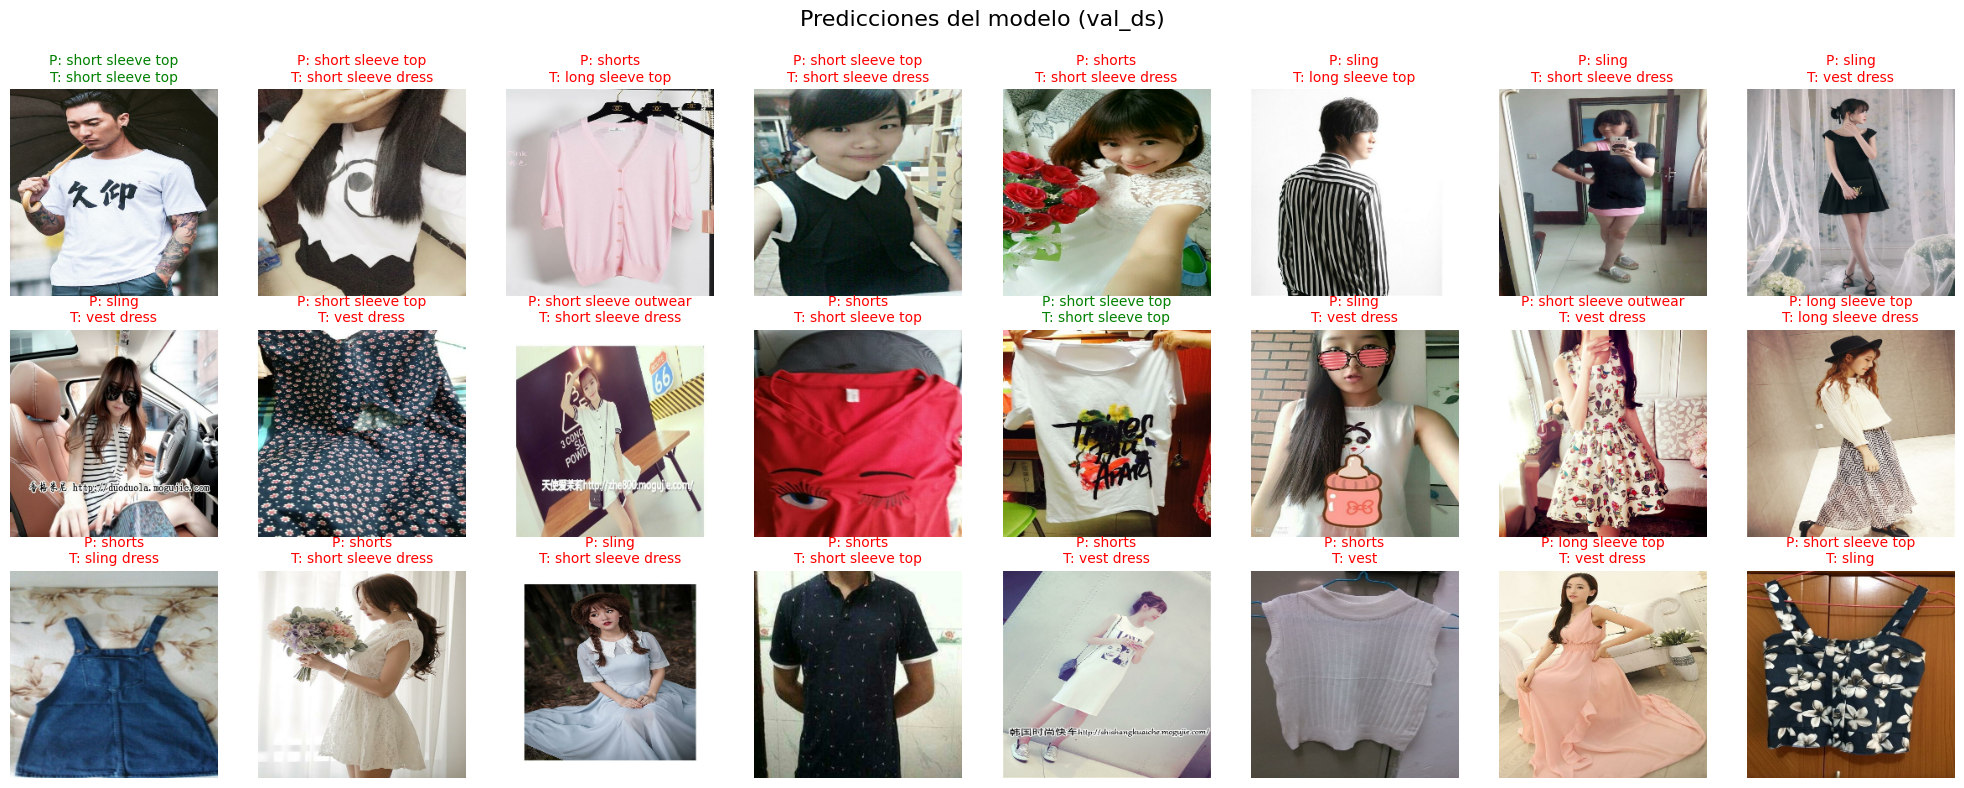

In [45]:


pred_probs = model_efficient.predict(val_images)
pred_labels = tf.argmax(pred_probs, axis=1)
#id2label = {item["category_id"]:item["category_name"] for item in df[["category_id", "category_name"]].drop_duplicates().to_dict("records")}
import matplotlib.pyplot as plt

# Mostrar 3x8 = 24 imágenes
rows, cols = 3, 8
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
fig.suptitle("Predicciones del modelo (val_ds)", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i >= len(val_images):
        break
    image = val_images[i].numpy()
    true_label = val_labels[i].numpy()
    pred_label = pred_labels[i].numpy()

    ax.imshow(image)
    title = f"P: {id2label[pred_label]}\nT: {id2label[int(true_label)]}"
    color = "green" if pred_label == true_label else "red"
    ax.set_title(title, color=color, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


In [5]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.metrics import top_k_categorical_accuracy

def sparse_top_k_categorical_accuracy(y_true, y_pred, k=4):
    # Convierte etiquetas de enteros a one-hot para que funcione con top_k
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    return top_k_categorical_accuracy(y_true, y_pred, k=k)

    
model = MobileNet(include_top=True, weights=None, input_shape=(124, 124, 3), classes=13)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',
        lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=4)]
)

In [6]:
#train_ds = prepare_dataset(df)
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    #class_weight=class_weight_dict
)

Epoch 1/20


I0000 00:00:1747134100.429473    3611 service.cc:152] XLA service 0x7fe5640037a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747134100.429498    3611 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-05-13 13:01:40.593551: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747134101.500972    3611 cuda_dnn.cc:529] Loaded cuDNN version 90300


      5/Unknown 18s 35ms/step - accuracy: 0.0686 - lambda: 0.3656 - loss: 2.5565   

I0000 00:00:1747134109.854003    3611 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    313/Unknown 32s 45ms/step - accuracy: 0.1883 - lambda: 0.5835 - loss: 2.3242

2025-05-13 13:02:04.053193: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-13 13:02:04.053221: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-13 13:02:04.053226: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:02:04.053231: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104
/home/carlos/miniconda3/envs/deeplearning_kernel/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `

313/313 ━━━━━━━━━━━━━━━━━━━━ 51s 105ms/step - accuracy: 0.1883 - lambda: 0.5836 - loss: 2.3240 - val_accuracy: 0.2392 - val_lambda: 0.6149 - val_loss: 2.2808
Epoch 2/20


2025-05-13 13:02:22.549826: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-13 13:02:22.549855: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:02:22.549874: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2307 - lambda: 0.6258 - loss: 2.2214

2025-05-13 13:02:29.835574: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:02:29.835606: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.2307 - lambda: 0.6258 - loss: 2.2215 - val_accuracy: 0.2198 - val_lambda: 0.5334 - val_loss: 2.2901
Epoch 3/20


2025-05-13 13:02:47.906443: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-13 13:02:47.906469: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:02:47.906487: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.2347 - lambda: 0.6333 - loss: 2.2128 - val_accuracy: 0.2269 - val_lambda: 0.6291 - val_loss: 2.2285
Epoch 4/20


2025-05-13 13:03:13.317941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:03:13.317972: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2292 - lambda: 0.6479 - loss: 2.1901

2025-05-13 13:03:20.653697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:03:20.653727: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.2292 - lambda: 0.6479 - loss: 2.1903 - val_accuracy: 0.2278 - val_lambda: 0.6241 - val_loss: 2.2484
Epoch 5/20


2025-05-13 13:03:35.884665: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-13 13:03:35.884691: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.2336 - lambda: 0.6438 - loss: 2.1951 - val_accuracy: 0.2054 - val_lambda: 0.6242 - val_loss: 2.2881
Epoch 6/20


2025-05-13 13:04:01.217063: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:04:01.217100: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2431 - lambda: 0.6518 - loss: 2.1716

2025-05-13 13:04:08.569748: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:04:08.569778: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.2430 - lambda: 0.6517 - loss: 2.1718 - val_accuracy: 0.2144 - val_lambda: 0.6098 - val_loss: 2.2624
Epoch 7/20


2025-05-13 13:04:26.720814: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:04:26.720856: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2438 - lambda: 0.6539 - loss: 2.1652

2025-05-13 13:04:33.897003: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:04:33.897061: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.2438 - lambda: 0.6538 - loss: 2.1653 - val_accuracy: 0.2065 - val_lambda: 0.6268 - val_loss: 2.2722
Epoch 8/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2496 - lambda: 0.6655 - loss: 2.1542

2025-05-13 13:04:59.037731: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:04:59.037760: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.2496 - lambda: 0.6654 - loss: 2.1543 - val_accuracy: 0.1974 - val_lambda: 0.6002 - val_loss: 2.2788
Epoch 9/20


2025-05-13 13:05:14.192231: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-13 13:05:14.192258: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:05:14.192277: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2607 - lambda: 0.6674 - loss: 2.1363

2025-05-13 13:05:21.393040: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:05:21.393069: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.2604 - lambda: 0.6673 - loss: 2.1366 - val_accuracy: 0.2299 - val_lambda: 0.6158 - val_loss: 2.2925
Epoch 10/20


2025-05-13 13:05:39.226970: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:05:39.227010: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2695 - lambda: 0.6675 - loss: 2.1234

2025-05-13 13:05:46.467708: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:05:46.467741: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.2692 - lambda: 0.6674 - loss: 2.1236 - val_accuracy: 0.2068 - val_lambda: 0.6192 - val_loss: 2.3022
Epoch 11/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.2704 - lambda: 0.6801 - loss: 2.1056 - val_accuracy: 0.2237 - val_lambda: 0.6322 - val_loss: 2.2622
Epoch 12/20


2025-05-13 13:06:28.305724: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:06:28.305759: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2735 - lambda: 0.6807 - loss: 2.0825

2025-05-13 13:06:35.326613: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:06:35.326644: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.2734 - lambda: 0.6808 - loss: 2.0826 - val_accuracy: 0.1918 - val_lambda: 0.6003 - val_loss: 2.3148
Epoch 13/20


2025-05-13 13:06:53.549883: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:06:53.549927: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.2847 - lambda: 0.7090 - loss: 2.0461 - val_accuracy: 0.2042 - val_lambda: 0.5811 - val_loss: 2.3350
Epoch 14/20


2025-05-13 13:07:19.608097: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:07:19.608133: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2849 - lambda: 0.7000 - loss: 2.0486

2025-05-13 13:07:26.753929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:07:26.753959: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.2848 - lambda: 0.6999 - loss: 2.0490 - val_accuracy: 0.2085 - val_lambda: 0.6245 - val_loss: 2.3460
Epoch 15/20


2025-05-13 13:07:42.027635: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:07:42.027675: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2932 - lambda: 0.6975 - loss: 2.0402

2025-05-13 13:07:49.267095: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:07:49.267125: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.2931 - lambda: 0.6974 - loss: 2.0405 - val_accuracy: 0.1960 - val_lambda: 0.5993 - val_loss: 2.3420
Epoch 16/20


2025-05-13 13:08:07.314666: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:08:07.314703: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.3075 - lambda: 0.7110 - loss: 2.0111 - val_accuracy: 0.1960 - val_lambda: 0.5924 - val_loss: 2.3772
Epoch 17/20


2025-05-13 13:08:32.500240: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-13 13:08:32.500268: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:08:32.500286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.3169 - lambda: 0.7284 - loss: 1.9769 - val_accuracy: 0.1987 - val_lambda: 0.6108 - val_loss: 2.3614
Epoch 18/20


2025-05-13 13:08:55.036285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:08:55.036323: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3484 - lambda: 0.7435 - loss: 1.9037

2025-05-13 13:09:05.141508: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:09:05.141535: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.3483 - lambda: 0.7435 - loss: 1.9038 - val_accuracy: 0.1893 - val_lambda: 0.5573 - val_loss: 2.5471
Epoch 19/20


2025-05-13 13:09:20.627381: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:09:20.627440: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3656 - lambda: 0.7607 - loss: 1.8524

2025-05-13 13:09:28.022504: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:09:28.022532: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - accuracy: 0.3655 - lambda: 0.7606 - loss: 1.8526 - val_accuracy: 0.2061 - val_lambda: 0.5932 - val_loss: 2.4952
Epoch 20/20


2025-05-13 13:09:46.502137: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:09:46.502176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.3890 - lambda: 0.7885 - loss: 1.7801 - val_accuracy: 0.1769 - val_lambda: 0.5711 - val_loss: 2.5681


2025-05-13 13:10:09.178282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:10:09.178325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


{4: 'long sleeve outwear',
 8: 'trousers',
 1: 'short sleeve top',
 9: 'skirt',
 10: 'short sleeve dress',
 7: 'shorts',
 5: 'vest',
 12: 'vest dress',
 2: 'long sleeve top',
 11: 'long sleeve dress',
 13: 'sling dress',
 6: 'sling',
 3: 'short sleeve outwear'}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


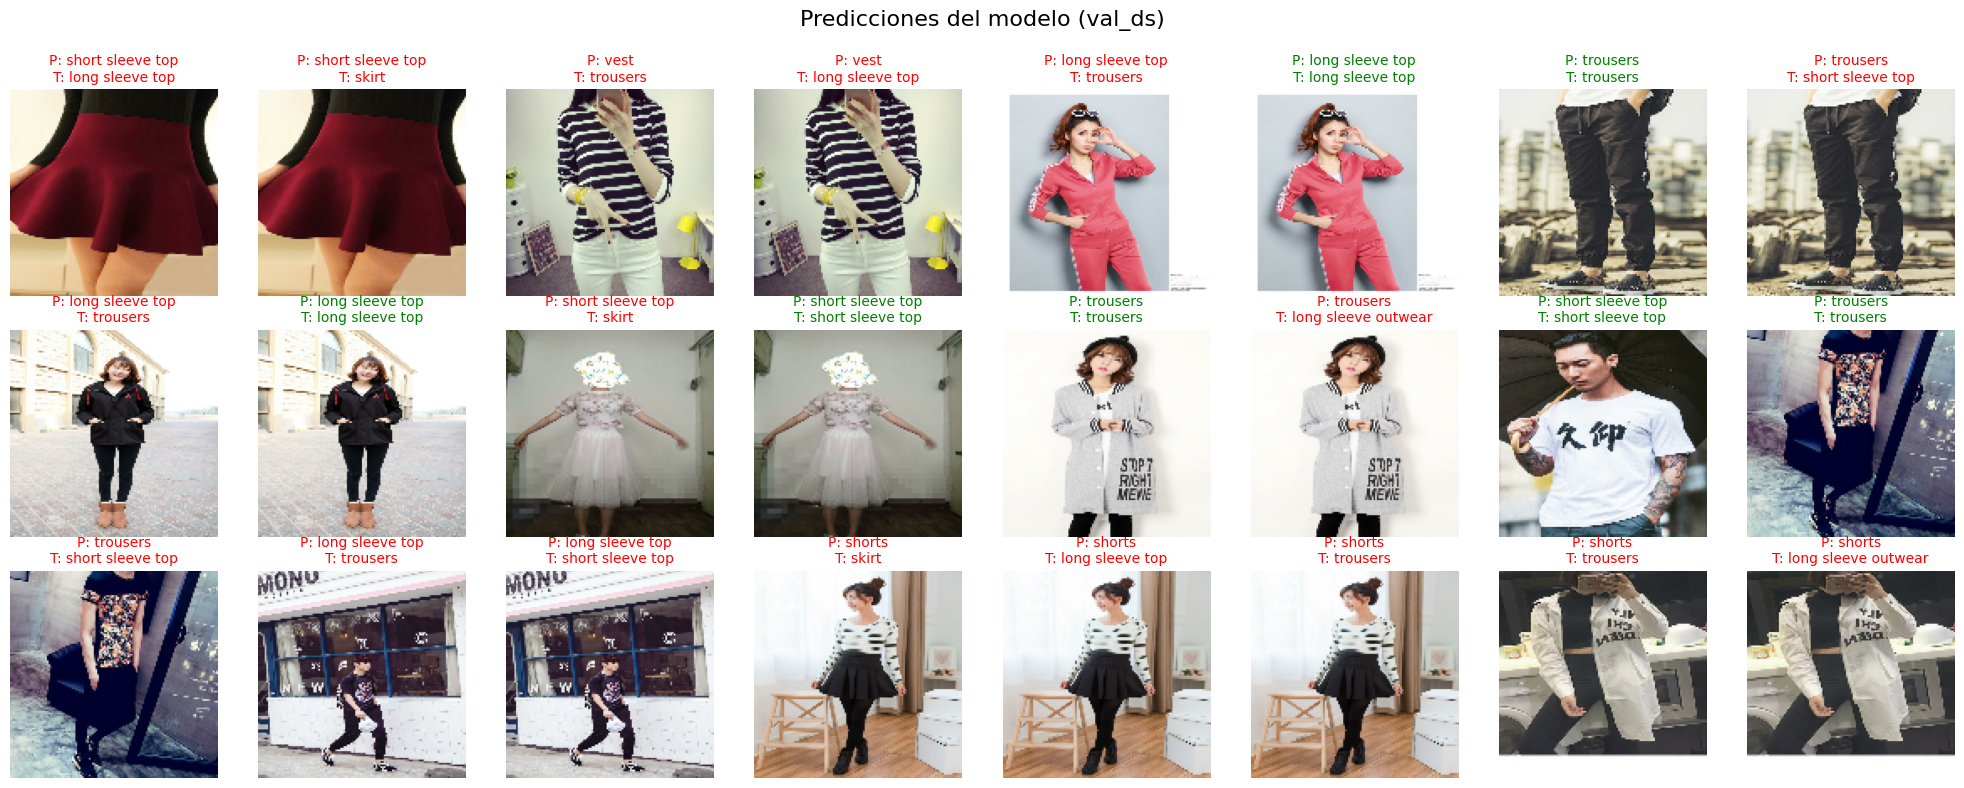

In [7]:
val_images, val_labels = next(iter(val_ds))
pred_probs = model.predict(val_images)
pred_labels = tf.argmax(pred_probs, axis=1)
#id2label = {item["category_id"]:item["category_name"] for item in df[["category_id", "category_name"]].drop_duplicates().to_dict("records")}
import matplotlib.pyplot as plt

# Mostrar 3x8 = 24 imágenes
rows, cols = 3, 8
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
fig.suptitle("Predicciones del modelo (val_ds)", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i >= len(val_images):
        break
    image = val_images[i].numpy()
    true_label = val_labels[i].numpy()
    pred_label = pred_labels[i].numpy()

    ax.imshow(image)
    title = f"P: {id2label[pred_label]}\nT: {id2label[int(true_label)]}"
    color = "green" if pred_label == true_label else "red"
    ax.set_title(title, color=color, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


In [8]:
model.save("models/mobilenet/last.keras")

/home/carlos/miniconda3/envs/deeplearning_kernel/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:145: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=4)]

  config_arr = [serialize_keras_object(x) for x in obj]


# Efficient

In [12]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers, models

def sparse_top_k_categorical_accuracy(y_true, y_pred, k=4):
    # Convierte etiquetas de enteros a one-hot para que funcione con top_k
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    return top_k_categorical_accuracy(y_true, y_pred, k=k)
    
base_model = EfficientNetV2B0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
base_model.trainable = False  # Fine-tune más adelante si quieres

model_efficient = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(len(label2id), activation="softmax")
])

model_efficient.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy",
        lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=4)]
)

In [13]:
#train_ds = prepare_dataset(df)
history = model_efficient.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    #class_weight=class_weight_dict
)

Epoch 1/20
    313/Unknown 27s 37ms/step - accuracy: 0.1561 - lambda: 0.5014 - loss: 2.4042

2025-05-13 13:35:50.526965: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:35:50.526993: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - accuracy: 0.1562 - lambda: 0.5017 - loss: 2.4038 - val_accuracy: 0.2392 - val_lambda: 0.6149 - val_loss: 2.2223
Epoch 2/20
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2231 - lambda: 0.6353 - loss: 2.2278 

2025-05-13 13:36:22.414579: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:36:22.414607: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - accuracy: 0.2230 - lambda: 0.6352 - loss: 2.2279 - val_accuracy: 0.2392 - val_lambda: 0.6149 - val_loss: 2.2109
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.2183 - lambda: 0.6378 - loss: 2.2190 - val_accuracy: 0.2392 - val_lambda: 0.6149 - val_loss: 2.2144
Epoch 4/20


2025-05-13 13:37:06.812963: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:37:06.812988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2147 - lambda: 0.6367 - loss: 2.2285 

2025-05-13 13:37:13.167154: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-13 13:37:13.167183: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:37:13.167189: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.2147 - lambda: 0.6367 - loss: 2.2285 - val_accuracy: 0.2376 - val_lambda: 0.6149 - val_loss: 2.2148
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.2164 - lambda: 0.6354 - loss: 2.2177 - val_accuracy: 0.2392 - val_lambda: 0.6149 - val_loss: 2.2080
Epoch 6/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2217 - lambda: 0.6392 - loss: 2.2247

2025-05-13 13:38:06.559917: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.2217 - lambda: 0.6391 - loss: 2.2247 - val_accuracy: 0.2392 - val_lambda: 0.6149 - val_loss: 2.2095
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2223 - lambda: 0.6354 - loss: 2.2222 

2025-05-13 13:38:30.089901: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:38:30.089928: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.2223 - lambda: 0.6354 - loss: 2.2222 - val_accuracy: 0.2392 - val_lambda: 0.6149 - val_loss: 2.2068
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.2246 - lambda: 0.6323 - loss: 2.2278 - val_accuracy: 0.2392 - val_lambda: 0.6149 - val_loss: 2.2068
Epoch 9/20
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2181 - lambda: 0.6402 - loss: 2.2163

2025-05-13 13:39:23.979069: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:39:23.979099: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.2181 - lambda: 0.6401 - loss: 2.2165 - val_accuracy: 0.2391 - val_lambda: 0.6149 - val_loss: 2.2101
Epoch 10/20


2025-05-13 13:39:41.011002: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.2189 - lambda: 0.6377 - loss: 2.2318 - val_accuracy: 0.2392 - val_lambda: 0.6149 - val_loss: 2.2034
Epoch 11/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2266 - lambda: 0.6356 - loss: 2.2174 

2025-05-13 13:40:13.879111: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:40:13.879138: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.2266 - lambda: 0.6356 - loss: 2.2174 - val_accuracy: 0.2372 - val_lambda: 0.6149 - val_loss: 2.2073
Epoch 12/20


2025-05-13 13:40:34.062077: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:40:34.062104: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.2153 - lambda: 0.6384 - loss: 2.2149 - val_accuracy: 0.2391 - val_lambda: 0.6149 - val_loss: 2.2113
Epoch 13/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.2226 - lambda: 0.6331 - loss: 2.2242 - val_accuracy: 0.2390 - val_lambda: 0.6149 - val_loss: 2.2118
Epoch 14/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2118 - lambda: 0.6273 - loss: 2.2316 

2025-05-13 13:41:30.025102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:41:30.025133: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.2118 - lambda: 0.6273 - loss: 2.2316 - val_accuracy: 0.2385 - val_lambda: 0.6149 - val_loss: 2.2042
Epoch 15/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2110 - lambda: 0.6277 - loss: 2.2291 

2025-05-13 13:41:56.351705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:41:56.351732: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.2110 - lambda: 0.6277 - loss: 2.2291 - val_accuracy: 0.2389 - val_lambda: 0.6149 - val_loss: 2.2070
Epoch 16/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.2189 - lambda: 0.6347 - loss: 2.2212 - val_accuracy: 0.2391 - val_lambda: 0.6149 - val_loss: 2.2060
Epoch 17/20


2025-05-13 13:42:39.825109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12292345818821348395
2025-05-13 13:42:39.825136: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3799665147974704104


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.2117 - lambda: 0.6282 - loss: 2.2303 - val_accuracy: 0.2391 - val_lambda: 0.6149 - val_loss: 2.2003
Epoch 18/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.2222 - lambda: 0.6432 - loss: 2.2116 - val_accuracy: 0.2390 - val_lambda: 0.6149 - val_loss: 2.2055
Epoch 19/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.2172 - lambda: 0.6274 - loss: 2.2279 - val_accuracy: 0.2381 - val_lambda: 0.6149 - val_loss: 2.2099
Epoch 20/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.2179 - lambda: 0.6441 - loss: 2.2134 - val_accuracy: 0.2387 - val_lambda: 0.6149 - val_loss: 2.2026


In [16]:
model_efficient.save("models/efficientv2b0_freezed/model.keras")

/home/carlos/miniconda3/envs/deeplearning_kernel/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:145: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=4)]

  config_arr = [serialize_keras_object(x) for x in obj]


{'long sleeve outwear': 0,
 'trousers': 1,
 'short sleeve top': 2,
 'skirt': 3,
 'short sleeve dress': 4,
 'shorts': 5,
 'vest': 6,
 'vest dress': 7,
 'long sleeve top': 8,
 'long sleeve dress': 9,
 'sling dress': 10,
 'sling': 11,
 'short sleeve outwear': 12}

{0: 'long sleeve outwear',
 1: 'trousers',
 2: 'short sleeve top',
 3: 'skirt',
 4: 'short sleeve dress',
 5: 'shorts',
 6: 'vest',
 7: 'vest dress',
 8: 'long sleeve top',
 9: 'long sleeve dress',
 10: 'sling dress',
 11: 'sling',
 12: 'short sleeve outwear'}